# Fake News Analysis

## Spark

In [2]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
    .appName("csv-demo")
    .master("local[2]")          # fewer cores = less thrash on slow machines
    .config("spark.sql.shuffle.partitions", "4")
    .config("spark.driver.memory", "1g")   # adjust down if you have low RAM
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")


### Stage one: Data Load (Raw Data)

We begin by loading the original CSV files in their raw form to inspect the schema and understand the structure of the dataset before any cleaning or preprocessing steps are applied.


In [23]:


FAKE_CSV = r"\Users\carin\OneDrive\Desktop\ibd\fake-news-detection-spark\data\raw\News_dataset\Fake.csv"
TRUE_CSV = r"C:\Users\carin\OneDrive\Desktop\ibd\fake-news-detection-spark\data\raw\News_dataset\True.csv"

fake_raw = (
    spark.read
    .option("header", True)
    .option("multiLine", True)
    .option("escape", '"')
    .option("quote", '"')
    .csv(FAKE_CSV)
    .limit(10)   # demo only
)

true_raw = (
    spark.read
    .option("header", True)
    .option("multiLine", True)
    .option("escape", '"')
    .option("quote", '"')
    .csv(TRUE_CSV)
    .limit(10)   # demo only
)

In [8]:
print("Fake news schema:")
fake_raw.show(3, truncate=80)


print("Real news schema:")
true_raw.show(3, truncate=80)

Fake news schema:
+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+-------+-----------------+
|                                                                           title|                                                                            text|subject|             date|
+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+-------+-----------------+
|  Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing|Donald Trump just couldn t wish all Americans a Happy New Year and leave it a...|   News|December 31, 2017|
|            Drunk Bragging Trump Staffer Started Russian Collusion Investigation|House Intelligence Committee Chairman Devin Nunes is going to have a bad day....|   News|December 31, 2017|
| Sheriff David Clarke Becomes A

### Stage 2: Labeling and combining


At this stage, the two source files (`True.csv` and `Fake.csv`) are converted into a supervised learning dataset.
Each article is assigned a binary label (`1` for true news, `0` for fake news), and both datasets are merged into a single DataFrame using a consistent schema.

The implementation shown here uses the same loading and labeling logic as the full pipeline, but is applied to a small mock sample for demonstration purposes.


In [25]:
import importlib
import src.data.load as load
importlib.reload(load)

<module 'src.data.load' from 'c:\\Users\\carin\\OneDrive\\Desktop\\ibd\\fake-news-detection-spark\\src\\data\\load.py'>

In [24]:
print(hasattr(load, "load_label"))
print([n for n in dir(load) if "label" in n.lower()])


True
['load_label']


In [31]:
from src.data.load import load_label

df_demo, meta_demo = load_label(true_raw, fake_raw)
df_demo.select("title", "text", "label").show(20, truncate=80)



+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+-----+
|                                                                           title|                                                                            text|label|
+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+-----+
|                As U.S. budget fight looms, Republicans flip their fiscal script|WASHINGTON (Reuters) - The head of a conservative Republican faction in the U...|    1|
|                U.S. military to accept transgender recruits on Monday: Pentagon|WASHINGTON (Reuters) - Transgender people will be allowed for the first time ...|    1|
|                    Senior U.S. Republican senator: 'Let Mr. Mueller do his job'|WASHINGTON (Reuters) - The special counsel investigation of links be

### Stage 3: Data Cleaning


Before feature extraction and modeling, we apply a lightweight cleaning pipeline to improve data quality and reduce noise:
- Remove rows with missing or empty `title` / `text`
- Normalize text (lowercase + trim + whitespace normalization)
- Remove HTML tags from `text`
- Parse `date` tolerantly (invalid formats become null)
- Filter out very short articles to remove low-information rows

This cleaning is applied consistently to both datasets (FAKE and REAL) before labeling and combining.


In [29]:
from src.data.clean import clean_text_df

df_clean_demo, fake_meta = clean_text_df(df_demo, min_text_length=30, dedup=True, cache=False)


df_clean_demo.select("title", "text", "label").show(2, truncate=80)

+----------------------------------------------------------------+--------------------------------------------------------------------------------+-----+
|                                                           title|                                                                            text|label|
+----------------------------------------------------------------+--------------------------------------------------------------------------------+-----+
|    senior u.s. republican senator: 'let mr. mueller do his job'|washington (reuters) - the special counsel investigation of links between rus...|    1|
|as u.s. budget fight looms, republicans flip their fiscal script|washington (reuters) - the head of a conservative republican faction in the u...|    1|
+----------------------------------------------------------------+--------------------------------------------------------------------------------+-----+
only showing top 2 rows


### Stage 4: Exploratory Data Analysis
EDA is used to inspect the structure and basic properties of the dataset before modeling. We analyze class balance, article length statistics, and selected textual patterns to validate preprocessing choices and identify potential biases. These observations guide feature engineering and model selection.

In [5]:
import src.utils.eda as eda
print(eda.__file__)


c:\Users\carin\OneDrive\Desktop\ibd\fake-news-detection-spark\src\utils\eda.py


In [3]:
import importlib
import src.utils.eda as eda

importlib.reload(eda)


<module 'src.utils.eda' from 'c:\\Users\\carin\\OneDrive\\Desktop\\ibd\\fake-news-detection-spark\\src\\utils\\eda.py'>

In [5]:
from src.utils.eda import get_eda_dataframe

RAW_DATA_DIR = r"C:\Users\carin\OneDrive\Desktop\ibd\fake-news-detection-spark\data\raw\News_dataset"

df_all = get_eda_dataframe(spark, RAW_DATA_DIR)


In [24]:
from pyspark.sql import functions as F

df_stats = (
    df_all
    .withColumn("text_length", F.length("text"))
    .groupBy("label")
    .agg(
        F.count("*").alias("count"),
        F.min("text_length").alias("min_len"),
        F.max("text_length").alias("max_len"),
        F.avg("text_length").alias("avg_len")
    )
    .orderBy("label")
)

df_stats.show()


+-----+-----+-------+-------+------------------+
|label|count|min_len|max_len|           avg_len|
+-----+-----+-------+-------+------------------+
|    0|17405|     30|  51493|2541.8367135880494|
|    1|21190|    151|  29776| 2369.778905143936|
+-----+-----+-------+-------+------------------+



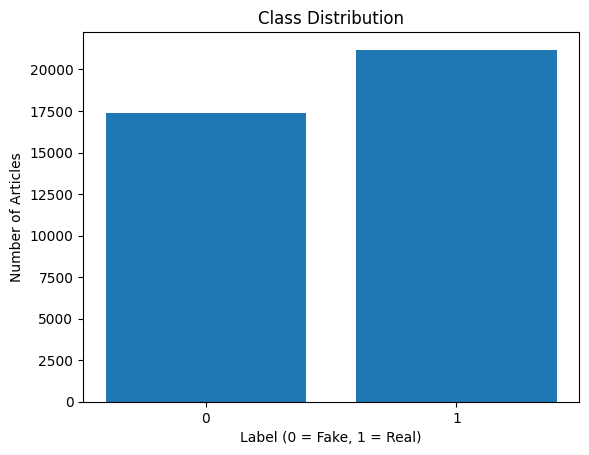

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

label_counts = (
    df_all
    .groupBy("label")
    .count()
    .orderBy("label")
)

pdf = label_counts.toPandas()   # ✅ FIXED

plt.figure()
plt.bar(pdf["label"].astype(str), pdf["count"])
plt.xlabel("Label (0 = Fake, 1 = Real)")
plt.ylabel("Number of Articles")
plt.title("Class Distribution")
plt.show()


In [8]:
from pyspark.sql import functions as F

length_stats = (
    df_all
    .withColumn("text_length", F.length("text"))
    .groupBy("label")
    .agg(
        F.min("text_length").alias("min_len"),
        F.expr("percentile(text_length, 0.5)").alias("median_len"),
        F.avg("text_length").alias("avg_len"),
        F.max("text_length").alias("max_len")
    )
    .orderBy("label")
)

rows = length_stats.collect()


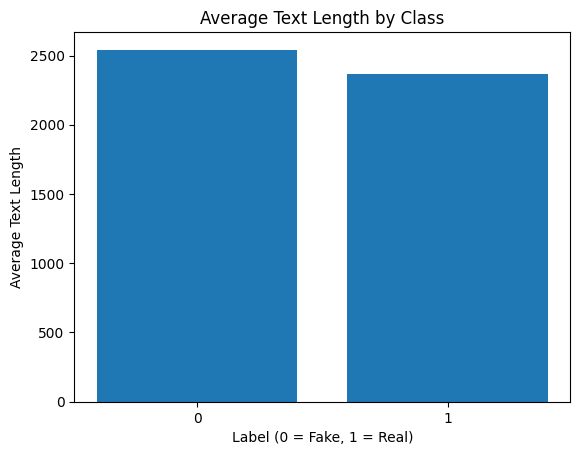

In [9]:
import matplotlib.pyplot as plt

labels = [str(r["label"]) for r in rows]
avg_len = [r["avg_len"] for r in rows]

plt.figure()
plt.bar(labels, avg_len)
plt.xlabel("Label (0 = Fake, 1 = Real)")
plt.ylabel("Average Text Length")
plt.title("Average Text Length by Class")
plt.show()


In [ ]:
from pyspark.sql import functions as F

top_k = 6

# total counts per subject -> pick top K
top_subjects = (
    df_all.groupBy("subject")
    .count()
    .orderBy(F.desc("count"))
    .limit(top_k)
    .select("subject")
)

# counts per subject per label, pivot labels into columns 0 and 1
subj_pivot = (
    df_all.join(top_subjects, on="subject", how="inner")
    .groupBy("subject")
    .pivot("label", [0, 1])
    .count()
    .fillna(0)
    .orderBy("subject")
)

subj_pivot.show()
rows = subj_pivot.collect()


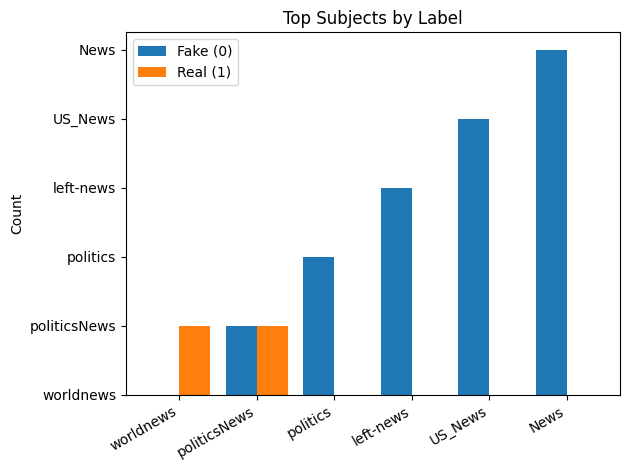

In [15]:
import matplotlib.pyplot as plt
import numpy as np

subjects = [r["subject"] for r in rows]
counts_0 = [r[0] for r in rows]   # label 0 column
counts_1 = [r[1] for r in rows]   # label 1 column

x = np.arange(len(subjects))

plt.figure()
plt.bar(x - 0.2, counts_0, width=0.4, label="Fake (0)")
plt.bar(x + 0.2, counts_1, width=0.4, label="Real (1)")
plt.xticks(x, subjects, rotation=30, ha="right")
plt.ylabel("Count")
plt.title("Top Subjects by Label")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
from pyspark.sql import functions as F
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover

# Tokenize + remove stopwords (same logic as your pipeline)
tokenizer = RegexTokenizer(
    inputCol="text",
    outputCol="tokens",
    pattern=r"[^a-zA-Z]+",
    toLowercase=True,
    minTokenLength=2
)

remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="filtered_tokens",
    stopWords=StopWordsRemover.loadDefaultStopWords("english"),
    caseSensitive=False
)

df_tok = tokenizer.transform(df_all.select("text", "label"))
df_tok = remover.transform(df_tok).select("label", F.explode("filtered_tokens").alias("word"))


In [17]:
top_k = 15

top_words = (
    df_tok
    .groupBy("label", "word")
    .count()
    .orderBy(F.desc("count"))
)

top_fake = top_words.filter(F.col("label") == 0).limit(top_k).collect()
top_real = top_words.filter(F.col("label") == 1).limit(top_k).collect()


In [18]:
top_k = 15

top_words = (
    df_tok
    .groupBy("label", "word")
    .count()
    .orderBy(F.desc("count"))
)

top_fake = top_words.filter(F.col("label") == 0).limit(top_k).collect()
top_real = top_words.filter(F.col("label") == 1).limit(top_k).collect()


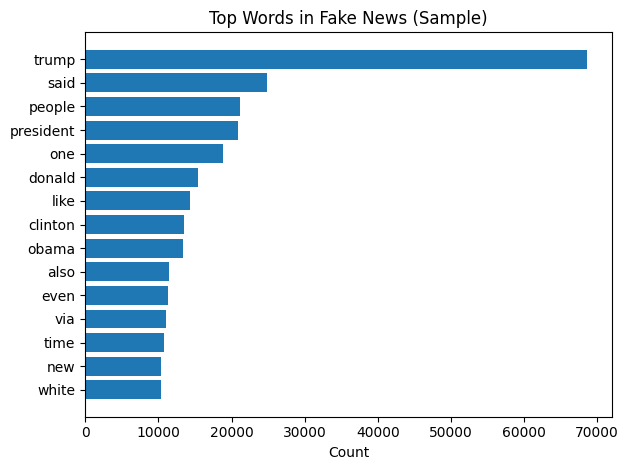

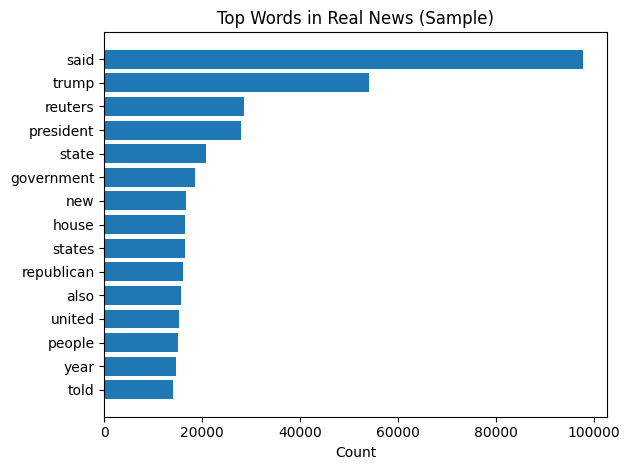

In [19]:
import matplotlib.pyplot as plt

# Fake
words_f = [r["word"] for r in top_fake][::-1]
counts_f = [r["count"] for r in top_fake][::-1]

plt.figure()
plt.barh(words_f, counts_f)
plt.xlabel("Count")
plt.title("Top Words in Fake News (Sample)")
plt.tight_layout()
plt.show()

# Real
words_r = [r["word"] for r in top_real][::-1]
counts_r = [r["count"] for r in top_real][::-1]

plt.figure()
plt.barh(words_r, counts_r)
plt.xlabel("Count")
plt.title("Top Words in Real News (Sample)")
plt.tight_layout()
plt.show()


### Stage 4 : Tokenization & Encoding (TF-IDF)

Machine learning models require numeric inputs, so we convert each article’s text into a vector representation.
We apply the following steps:

1. **Tokenization**: split text into word tokens using a regex tokenizer.
2. **Stopword removal**: remove common English words (e.g., "the", "and") that usually carry little meaning.
3. **Term Frequency (TF)**: build a vocabulary and represent each document by word occurrences.
4. **Inverse Document Frequency (IDF)**: down-weight very common terms and emphasize informative terms.

The output is a TF-IDF feature vector used by downstream classifiers.


In [32]:
df_feat_demo_base = df_demo.select("text", "label")
df_feat_demo_base.select("text", "label").show(2, truncate=80)

+--------------------------------------------------------------------------------+-----+
|                                                                            text|label|
+--------------------------------------------------------------------------------+-----+
|WASHINGTON (Reuters) - The head of a conservative Republican faction in the U...|    1|
|WASHINGTON (Reuters) - Transgender people will be allowed for the first time ...|    1|
+--------------------------------------------------------------------------------+-----+
only showing top 2 rows


In order to tokenize and encode the text data for machine learning, we used the following components from Spark ML, applied sequentially as part of a preprocessing pipeline:

**RegexTokenizer**:
Splits the raw text into individual word tokens using a regular expression and converts all tokens to lowercase.

**StopWordsRemover**:
Removes common English stopwords from the tokenized text to reduce noise in the feature space.

**CountVectorizer**:
Converts the filtered tokens into a sparse term-frequency vector based on a learned vocabulary.
A binary term-frequency representation is used to improve efficiency.

**IDF**:
Applies inverse document frequency weighting to the term-frequency vectors, producing TF-IDF features.

**Pipeline**:
Combines all preprocessing and feature extraction steps into a single reusable Spark ML pipeline.

In [33]:
from pyspark.ml import Pipeline
from src.features.text_features import build_text_feature_pipeline


# Build full pipeline but we'll also show intermediate columns after transform
pipe, meta = build_text_feature_pipeline(
    input_col="text",
    output_col="features",
    vocab_size=2000,   # small for demo speed
    min_df=1,          # important for small mock data
    binary_tf=True
)

print("Feature pipeline meta:", meta)

feat_model = pipe.fit(df_feat_demo_base)
df_encoded_demo = feat_model.transform(df_feat_demo_base)

# Show tokenization result (before/after stopwords)
df_encoded_demo.select("label", "tokens", "filtered_tokens").show(3, truncate=80)


Feature pipeline meta: {'input_col': 'text', 'output_col': 'features', 'vocab_size': 2000, 'min_df': 1, 'binary_tf': True, 'stages': ['RegexTokenizer', 'StopWordsRemover', 'CountVectorizer', 'IDF']}
+-----+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|label|                                                                          tokens|                                                                 filtered_tokens|
+-----+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|    1|[washington, reuters, the, head, of, conservative, republican, faction, in, t...|[washington, reuters, head, conservative, republican, faction, congress, vote...|
|    1|[washington, reuters, transgender, people, will, be, allowed, for, the, first...|[washington, reuters, transgender

# Models

In this section, we train and compare multiple classification models to distinguish between fake and real news articles using TF-IDF features derived from the article text. All models use the same feature representation to ensure a fair comparison. We focus on establishing strong baselines rather than extensive hyperparameter tuning and evaluate performance on a held-out test set.

### Logistical regression
Logistic Regression serves as a strong linear baseline for text classification tasks. It is well-suited for high-dimensional sparse TF-IDF features and provides interpretable coefficients, making it a common first choice for fake news detection.

In [30]:
import json
import numpy as np

path = r"C:\Users\carin\OneDrive\Desktop\ibd\fake-news-detection-spark\outputs\reports\model_weights\logreg_weights.json"

with open(path, "r") as f:
    model = json.load(f)

w = np.array(model["coefficients"])
b = 0.0  # no intercept stored

print("Loaded coefficients:", len(w))


Loaded coefficients: 20000


In [33]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict_proba_from_x(x):
    return float(sigmoid(np.dot(w, x) + b))

def predict_from_x(x, threshold=0.5):
    p = predict_proba_from_x(x)
    return p, int(p >= threshold)

# --- DEMO mapping (you pick a few indices) ---
# Choose indices that exist: 0 <= idx < len(w)
DEMO_VOCAB = {
    "trump": 1,
    "election": 6,
    "breaking": 27,
    "shocking": 90,
    "official": 140,
}

def demo_predict_text(text, tfidf_value=1.0):
    tokens = text.lower().split()
    x = np.zeros(len(w))

    used = []
    for t in tokens:
        if t in DEMO_VOCAB:
            x[DEMO_VOCAB[t]] = tfidf_value
            used.append(t)

    p, y = predict_from_x(x)
    return {
        "text": text,
        "matched_demo_words": used,
        "prob_class1": p,
        "prediction": y
    }


In [34]:
demo_predict_text("trump election")


{'text': 'trump election',
 'matched_demo_words': ['trump', 'election'],
 'prob_class1': 0.9602725706763994,
 'prediction': 1}

In [38]:
import numpy as np

def evaluate_logreg(y_true, y_prob, threshold=0.5):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    y_pred = (y_prob >= threshold).astype(int)

    tp = int(np.sum((y_true == 1) & (y_pred == 1)))
    tn = int(np.sum((y_true == 0) & (y_pred == 0)))
    fp = int(np.sum((y_true == 0) & (y_pred == 1)))
    fn = int(np.sum((y_true == 1) & (y_pred == 0)))

    accuracy  = (tp + tn) / max(tp + tn + fp + fn, 1)
    precision = tp / max(tp + fp, 1)
    recall    = tp / max(tp + fn, 1)
    f1        = 2 * precision * recall / max(precision + recall, 1e-9)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "threshold": threshold
    }


In [39]:
y_true = [1, 0, 1, 1, 0]
y_prob = [0.9, 0.2, 0.6, 0.4, 0.1]

evaluate_logreg(y_true, y_prob)


{'accuracy': 0.8,
 'precision': 1.0,
 'recall': 0.6666666666666666,
 'f1': 0.8,
 'tp': 2,
 'tn': 2,
 'fp': 0,
 'fn': 1,
 'threshold': 0.5}

### SVC

A Linear Support Vector Machine is used to learn a linear decision boundary in the TF-IDF feature space. It often performs competitively with Logistic Regression on text data, though it does not produce calibrated probability estimates in Spark.

In [35]:
import json
import numpy as np

path = r"C:\Users\carin\OneDrive\Desktop\ibd\fake-news-detection-spark\outputs\reports\model_weights\linearsvc_weights.json"

with open(path, "r") as f:
    model = json.load(f)

w = np.array(model["coefficients"])
b = 0.0  # intercept not saved

print("Loaded coefficients:", len(w))


Loaded coefficients: 20000


In [36]:
# Pick indices that exist: 0 <= idx < len(w)
DEMO_VOCAB = {
    "trump": 1,
    "election": 6,
    "breaking": 27,
    "shocking": 90,
    "official": 140,
}

def svm_score_from_x(x):
    return float(np.dot(w, x) + b)

def svm_predict_from_x(x):
    s = svm_score_from_x(x)
    return s, int(s >= 0)

def demo_predict_text_svm(text, value=1.0):
    tokens = text.lower().split()
    x = np.zeros(len(w))

    used = []
    for t in tokens:
        if t in DEMO_VOCAB:
            x[DEMO_VOCAB[t]] = value
            used.append(t)

    s, y = svm_predict_from_x(x)
    return {
        "text": text,
        "matched_demo_words": used,
        "svm_score": s,
        "prediction": y
    }


In [37]:
demo_predict_text_svm("trump election")


{'text': 'trump election',
 'matched_demo_words': ['trump', 'election'],
 'svm_score': 2.184227602324211,
 'prediction': 1}

In [40]:
def evaluate_svm(y_true, y_score, threshold=0.0):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    y_pred = (y_score >= threshold).astype(int)

    tp = int(np.sum((y_true == 1) & (y_pred == 1)))
    tn = int(np.sum((y_true == 0) & (y_pred == 0)))
    fp = int(np.sum((y_true == 0) & (y_pred == 1)))
    fn = int(np.sum((y_true == 1) & (y_pred == 0)))

    accuracy  = (tp + tn) / max(tp + tn + fp + fn, 1)
    precision = tp / max(tp + fp, 1)
    recall    = tp / max(tp + fn, 1)
    f1        = 2 * precision * recall / max(precision + recall, 1e-9)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "threshold": threshold
    }


In [41]:
y_true  = [1, 0, 1, 1, 0]
y_score = [2.1, -0.4, 0.3, -0.2, -1.1]

evaluate_svm(y_true, y_score)


{'accuracy': 0.8,
 'precision': 1.0,
 'recall': 0.6666666666666666,
 'f1': 0.8,
 'tp': 2,
 'tn': 2,
 'fp': 0,
 'fn': 1,
 'threshold': 0.0}

### Random Forest and GBTClassifier
**Random Forest** is included as a non-linear baseline to compare against linear models. While tree-based methods are not typically ideal for high-dimensional sparse text features, this model helps illustrate the limitations of such approaches on TF-IDF representations.

**Gradient-Boosted Trees** are evaluated as a more expressive non-linear model. Due to the high dimensionality of TF-IDF features, this model is expected to benefit from feature selection and is primarily included for comparison rather than as a primary solution.

**Effective number of features (N_eff)**:
Estimates how many features the model effectively relies on. Lower values mean the model concentrates importance on fewer features; higher values mean importance is spread more broadly.

**Top-50 cumulative importance**:
The fraction of total feature importance explained by the 50 most important features. Higher values indicate a more concentrated model.

**RF vs GBT Spearman correlation**:
Measures how similarly Random Forest and Gradient-Boosted Trees rank features by importance. Values close to 1 mean strong agreement; values near 0 indicate different feature focus.

In [42]:
# --- Minimal RF vs GBT artifact metrics (pasteable cell) ---
import json, os, math

ART_DIR = r"C:\Users\carin\OneDrive\Desktop\ibd\fake-news-detection-spark\outputs\reports\tree_artifacts"
RF = json.load(open(os.path.join(ART_DIR, "randomforest_artifacts.json")))
GBT = json.load(open(os.path.join(ART_DIR, "gbt_artifacts.json")))

def norm(v):
    s = sum(v)
    return [x / s for x in v] if s > 0 else v

def hhi(p):                      # concentration
    return sum(x * x for x in p)

def neff(p):                     # effective #features
    return 1.0 / hhi(p)

def topk_cum(p, k):
    return sum(sorted(p, reverse=True)[:k])

def spearman(a, b):
    ra = sorted(range(len(a)), key=lambda i: a[i])
    rb = sorted(range(len(b)), key=lambda i: b[i])
    ra = [ra.index(i) for i in range(len(a))]
    rb = [rb.index(i) for i in range(len(b))]
    ma, mb = sum(ra)/len(ra), sum(rb)/len(rb)
    num = sum((x-ma)*(y-mb) for x,y in zip(ra,rb))
    den = math.sqrt(sum((x-ma)**2 for x in ra) * sum((y-mb)**2 for y in rb))
    return num/den if den else float("nan")

rf_p = norm(RF["feature_importances"])
gbt_p = norm(GBT["feature_importances"])

print({
    "rf_N_eff": round(neff(rf_p), 1),
    "gbt_N_eff": round(neff(gbt_p), 1),
    "rf_top50_cum": round(topk_cum(rf_p, 50), 3),
    "gbt_top50_cum": round(topk_cum(gbt_p, 50), 3),
    "rf_vs_gbt_spearman": round(spearman(rf_p, gbt_p), 3),
})


{'rf_N_eff': 59.6, 'gbt_N_eff': 1.1, 'rf_top50_cum': 0.588, 'gbt_top50_cum': 0.999, 'rf_vs_gbt_spearman': 0.352}
